In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV, LassoLarsCV
import warnings
import sys
import os
import pickle
from sympy import *
# ignoramos os resultados NaN das funções pois vamos zera-los
np.seterr(invalid='ignore')
# nao quero warning de convergência
warnings.filterwarnings('ignore')

In [2]:
def getResults(fname):
    dataset = []
    algoritmo = []
    msre_l = []
    coef_l = []
    rede_l = []
    if os.path.exists(fname):
        fw = open(fname, 'rb')
        dataset, algoritmo, msre_l, coef_l, rede_l = pickle.load(fw)
        fw.close()
    return dataset, algoritmo, msre_l, coef_l, rede_l

In [3]:
def storeResults(dataset, algoritmo, msre_l, coef_l, rede_l, fname):
    fw = open(fname, 'wb')
    pickle.dump((dataset, algoritmo, msre_l, coef_l, rede_l), fw)
    fw.close()

In [4]:
def msre(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [5]:
def importaDados(fname):
    dataset = np.loadtxt(fname, delimiter=",")
    X = dataset[:, :-1]
    y = dataset[:, -1]
    return (X, y)

In [6]:
def geraRede(X, n_inter, inter_min=0, inter_max=3):
    n_inputs = X.shape[1]
    rede = np.random.randint(inter_min, inter_max, size=(n_inputs, n_inter))
    for i in range(0, n_inputs):
        if 0 in X[:,i]:
            rede[i,:] = np.absolute(rede[i,:])
    return rede

In [7]:
def transformData(X, rede):
    n_rows = X.shape[0]
    n_inter = rede.shape[1]
    layers = np.ndarray((n_rows, 3*n_inter))
    for i in range(0, n_inter*3, 3):
        power = X**rede[:,int(i/3)]
        layers[:,i] = np.prod(power,axis=1) # id
        layers[:,i+1] = np.cos(layers[:,i]) # cos
        layers[:,i+2] = np.sqrt(layers[:,i]) # sqrt
    cols = np.any(np.isnan(layers), axis=0)
    layers[:, cols] = 0
    cols = np.any(np.isinf(layers), axis=0)
    layers[:, cols] = 0
    return layers

In [8]:
def fit(X, y, algoritmo, n_inter, inter_min=0, inter_max=3):
    n_inputs = X.shape[1]
    rede = geraRede(X, n_inter, inter_min, inter_max)
    X_transf = transformData(X, rede)
    if algoritmo == 'lasso':
        modelo = LassoCV(max_iter=5e4, cv=3)
    elif algoritmo == 'lassoLars':
        modelo = LassoLarsCV(max_iter=5e4, cv=3)
    modelo.fit(X_transf, y)
    return rede, modelo

In [9]:
def predict(X, rede, modelo):
    X_transf = transformData(X, rede)
    y_hat = modelo.predict(X_transf)
    return y_hat

In [10]:
def expression(rede, coef, limiar):
    n_inter = rede.shape[1]
    n_inputs = rede.shape[0]
    fun = ['', 'cos', 'sqrt']
    expr = ''
    total = 0
    compl = 0
    for i in range(n_inter):
        inter = ''
        exps = 0
        for j in range(n_inputs):
            if rede[j,i] != 0:
                exps += 1
                inter = inter + f'x{j}**{rede[j,i]}*'
        inter = inter[:-1]
        transf = ''
        for f in range(3):
            k = (i*3)+f
            if np.absolute(coef[k]) > limiar:
                compl += exps
                total = total + 1
                transf = transf + f'{coef[k]}*{fun[f]}({inter}) + '
        expr = expr + transf
    expr = expr + f'{coef[k+1]}'
    return expr, total, compl

In [11]:
def evaluate(row, rede, coef, limiar):
    n_inter = rede.shape[1]
    n_inputs = rede.shape[0]
    total = 0.0
    for i in range(n_inter):
        inter = 1.0
        for j in range(n_inputs):
            inter *= np.power(float(row[j]),rede[j,i])
        transf = 0.0
        if np.absolute(coef[i*3+0]) > limiar:
            transf += coef[(i*3)+0]*inter
        if np.absolute(coef[i*3+1]) > limiar:
            transf += coef[(i*3)+1]*np.cos(inter)
        if np.absolute(coef[i*3+2]) > limiar:
            transf += coef[(i*3)+2]*np.sqrt(inter)
        total += transf
    total += coef[-1]
    return total

In [12]:
datasets = ['airfoil', 'concrete', 'cpu', 'energyCooling', 'energyHeating', 'forestfires', 'towerData', 'wineRed', 'wineWhite', 'yacht']
algoritmos = ['lassoLars', 'lassoLars', 'lassoLars', 'lassoLars', 'lassoLars', 'lasso', 'lassoLars', 'lassoLars', 'lassoLars', 'lassoLars']
ninters = [10, 500, 1000, 500, 500, 10, 10, 100, 100, 100]
inter_mins = [-2, -2, -3, -2, 0, -2, 0, -1, -1, -3]
inter_maxs = [2, 2, 3, 2, 4, 2, 2, 1, 1, 3]
pastas = ['0', '1', '2', '3', '4']

In [13]:
dataset_l = []
algoritmo_l = []
msre_l = []
coef_l = []
rede_l = []
compl_l = [0 for x in range(10)]

In [ ]:
# faça esse somente para rodar todos os testes novamente
for i in range(10):
    dataset_l.append(datasets[i])
    algoritmo_l.append(f'{algoritmos[i]} {ninters[i]} ({inter_mins[i]} {inter_maxs[i]})')
    msre_pastas = []
    coef_pastas = []
    rede_pastas  =[]
    print(datasets[i])
    for pasta in pastas:
        fileTrain = 'datasets/' + datasets[i] + '-train-' + pasta + '.dat'
        fileTest = 'datasets/' + datasets[i] + '-test-' + pasta + '.dat'
        X_train, y_train = importaDados(fileTrain)
        X_test, y_test = importaDados(fileTest)
        n = X_train.shape[1]
        rede, modelo = fit(X_train, y_train, algoritmos[i], ninters[i]*n, inter_mins[i], inter_maxs[i]+1)
        y_hat = predict(X_test, rede, modelo)
        msre_pastas.append(msre(y_test, y_hat))
        coef = np.append(modelo.coef_, modelo.intercept_)
        coef_pastas.append(coef)
        rede_pastas.append(rede)
    m = len(pastas)
    msre_medio = np.sum(msre_pastas)/m
    msre_l.append(msre_medio)
    min_i = np.argmin(msre_pastas)
    #print(f'{datasets[i]} {algoritmos[i]} {ninters[i]} ({inter_mins[i]} {inter_maxs[i]}) msre: {msre_medio}')
    #print('total de coeficientes não-zeros:', np.count_nonzero(coef_pastas[min_i]))
    coef_l.append(coef_pastas[min_i])
    rede_l.append(rede_pastas[min_i])

storeResults(dataset_l, algoritmo_l, msre_l, coef_l, rede_l, 'tests.pkl')

In [14]:
# faça esse ao invés da acima para carregar os resultados salvos
dataset_l, algoritmo_l, msre_l, coef_l, rede_l = getResults('tests.pkl')

In [15]:
thr = 1e-04
#thr = 0

In [14]:
init_printing(use_unicode=True)

In [18]:
expr, nz = expression(rede_l[0], coef_l[0], thr)
print(dataset_l[0], 'total de coeficientes não-zeros com thr', thr, ':', nz)

airfoil total de coeficientes não-zeros com thr 0 : 44


In [ ]:
sympify(expr)

In [ ]:
latex(sympify(expr))

In [38]:
for i in range(10):
    dataset_l.append(datasets[i])
    msre_total = 0
    for pasta in pastas:
        fileTest = 'datasets/' + datasets[i] + '-test-' + pasta + '.dat'
        X_test, y_test = importaDados(fileTest)
        m, n = X_test.shape
        y_hat = []
        for r in range(m):
            y_hat.append(evaluate(X_test[r], rede_l[i], coef_l[i], thr))
        msre_total += msre(y_test, y_hat)
    m = len(pastas)
    msre_medio = msre_total/m
    msre_l.append(msre_medio)
    expr, nz, compl = expression(rede_l[i], coef_l[i], thr)
    algoritmo_l.append(f'thr {thr} termos {nz}')
    compl_l.append(compl)

In [39]:
# gerar o dataframe de resultados
df_IT = pd.DataFrame({'dataset':dataset_l, 'algoritmo':algoritmo_l, 'rmse':msre_l, 'complexidade':compl_l})

In [40]:
# salvar o df no arquivo
fw = open('df_IT.pkl', 'wb')
pickle.dump(df_IT, fw)
fw.close()

In [16]:
# carregar o df do arquivo de resultados
fw = open('df_IT.pkl', 'rb')
df_IT = pickle.load(fw)
fw.close()

In [17]:
# carregar o df do arquivo de resultados dos outros algoritmos
fw = open('df_GS.pkl', 'rb')
df_GS = pickle.load(fw)
fw.close()

In [18]:
# unir os resultados desses testes com os testes do GridSearch
df = pd.concat([df_IT, df_GS], ignore_index=True)

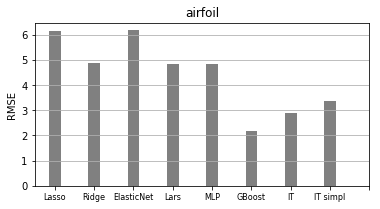

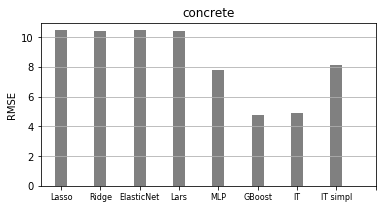

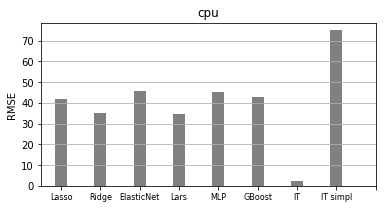

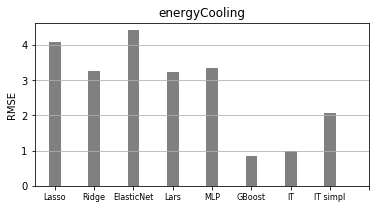

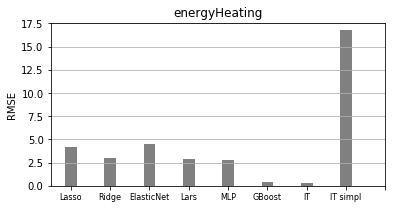

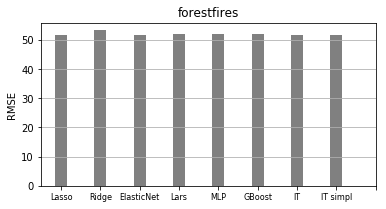

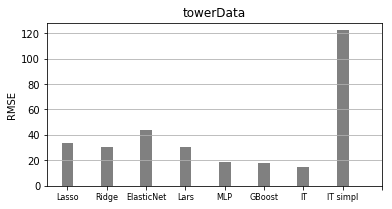

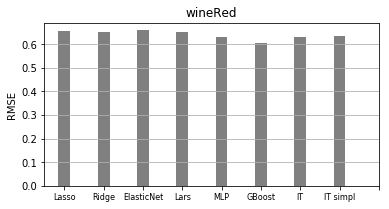

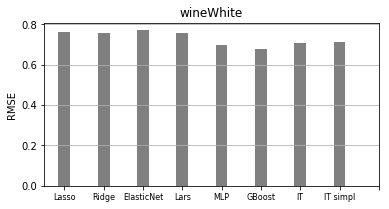

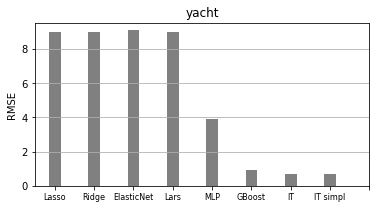

In [91]:
#barras para cada base de dados comparando os resultados de todos os algoritmos
algoritmos = ['Lasso', 'Ridge', 'ElasticNet', 'Lars', 'MLP', 'GBoost', 'IT', 'IT simpl']
datasets = df_IT.dataset.unique()
for D in datasets:
    S = list(df.loc[df['dataset'] == D].rmse)
    R = (S[4], S[3], S[6], S[5], S[8], S[7], S[1], S[2])
    plt.rc('xtick', labelsize=8)
    plt.figure(figsize=(6, 3))
    plt.bar(np.arange(8), R, align='center', width=0.3, color='gray')
    plt.xticks(x, algoritmos)
    plt.grid(b=None, which='major', axis='y')
    plt.title(D)
    plt.ylabel('RMSE')
    plt.show()

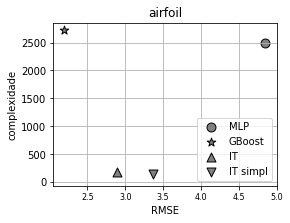

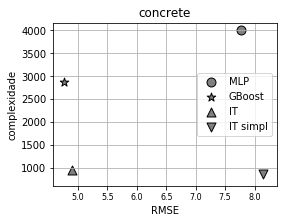

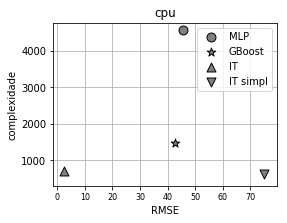

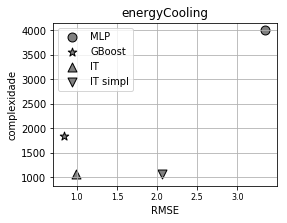

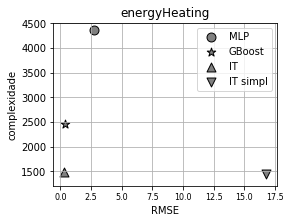

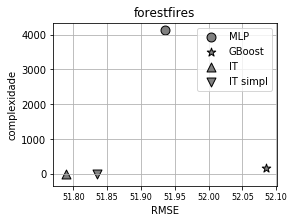

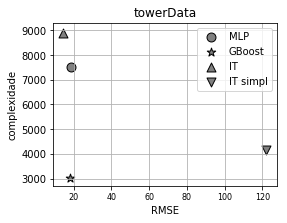

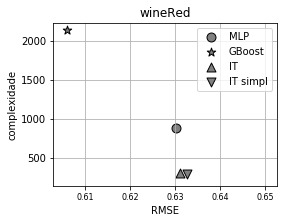

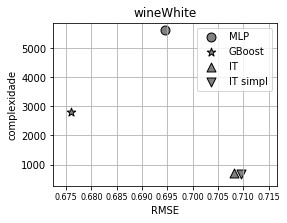

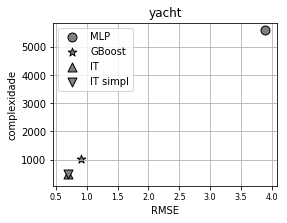

In [100]:
#scatter plot com um eixo sendo o rmse e outro a complexidade e cada algoritmo represenatdo por um símbolo diferente
datasets = df_IT.dataset.unique()
for D in datasets:
    S = list(df.loc[df['dataset'] == D].rmse)
    R = (S[8], S[7], S[1], S[2])
    S = list(df.loc[df['dataset'] == D].complexidade)
    C = (S[8], S[7], S[1], S[2])
    plt.figure(figsize=(4, 3))
    plt.scatter(R[0], C[0], s=80, c ='gray', edgecolors='black', marker='o', label='MLP')
    plt.scatter(R[1], C[1], s=80, c ='gray', edgecolors='black', marker='*', label='GBoost')
    plt.scatter(R[2], C[2], s=80, c ='gray', edgecolors='black', marker='^', label='IT')
    plt.scatter(R[3], C[3], s=80, c ='gray', edgecolors='black', marker='v', label='IT simpl')
    plt.grid(True)
    plt.title(D)
    plt.xlabel('RMSE')
    plt.ylabel('complexidade')
    plt.legend(numpoints=1)
    plt.draw()

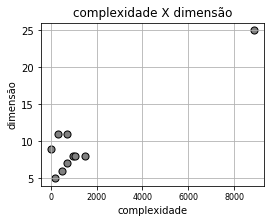

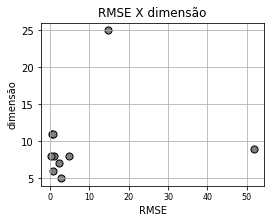

In [112]:
#scatter plot para apenas o IT-ELM, um traçando a dimensão da base de dados X complexidade e outro dimensão da base de dados X rmse
datasets = df_IT.dataset.unique()
R = []
C = []
T = [5, 8, 7, 8, 8, 9, 25, 11, 11, 6]
for D in datasets:
    S = list(df.loc[df['dataset'] == D].rmse)
    R.append(S[1])
    S = list(df.loc[df['dataset'] == D].complexidade)
    C.append(S[1])
    
plt.figure(figsize=(4, 3))
plt.scatter(C, T, s=50, c ='gray', edgecolors='black', marker='o')
plt.grid(True)
plt.title('complexidade X dimensão')
plt.xlabel('complexidade')
plt.ylabel('dimensão')
plt.draw()

plt.figure(figsize=(4, 3))
plt.scatter(R, T, s=50, c ='gray', edgecolors='black', marker='o')
plt.grid(True)
plt.title('RMSE X dimensão')
plt.xlabel('RMSE')
plt.ylabel('dimensão')
plt.draw()